<a href="https://colab.research.google.com/github/SaketMunda/time-series-with-tensorflow/blob/master/time_series_with_tensorflow_bitpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 3: Time series forecasting in Tensorflow (BitPredict 💰📈)

The goal of this notebook is to get familiar working with Time series data.

We're going to be building a series of models in an attempt to predict the price of Bitcoin.

In [1]:
# check for gpu
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



## Get the data

To build a time series forecasting model, the first thing we're going to need is data.

So we're going to get the data of Bitcoin from some source like [Yahoo Finance](https://finance.yahoo.com/quote/BTC-USD/history?period1=1410912000&period2=1679356800&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true) in csv format.

I've downloaded it in csv format and currently in the [github repo](https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv).

Let's download it into the colab and view what it looks like.

In [2]:
!wget https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv

--2023-03-29 02:25:53--  https://raw.githubusercontent.com/SaketMunda/time-series-with-tensorflow/master/BTC-USD.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 255951 (250K) [text/plain]
Saving to: ‘BTC-USD.csv’

BTC-USD.csv         100%[===================>] 249.95K  --.-KB/s    in 0.005s  

2023-03-29 02:25:53 (49.5 MB/s) - ‘BTC-USD.csv’ saved [255951/255951]



### Importing time series data with pandas

In [3]:
## read with pandas
import pandas as pd

df = pd.read_csv('/content/BTC-USD.csv', parse_dates=['Date'], index_col=['Date'])
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [4]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-17,25055.123047,27787.812500,24955.169922,27423.929688,27423.929688,50730261335
2023-03-18,27448.117188,27725.953125,26636.261719,26965.878906,26965.878906,35723036817
2023-03-19,26969.503906,28440.560547,26907.716797,28038.675781,28038.675781,37769448859
2023-03-20,28041.601563,28527.724609,27242.880859,27767.236328,27767.236328,44774027664
2023-03-21,27784.175781,27980.882813,27737.007813,27964.888672,27964.888672,41356222464


So we have daily prices of Bitcoin from **17th Sept 2014** to **21st March 2023**, almost 8+ years

In [5]:
len(df)

3108

In [6]:
3108/365

8.515068493150684

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3108 entries, 2014-09-17 to 2023-03-21
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3108 non-null   float64
 1   High       3108 non-null   float64
 2   Low        3108 non-null   float64
 3   Close      3108 non-null   float64
 4   Adj Close  3108 non-null   float64
 5   Volume     3108 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 170.0 KB


Different types of Time Series Data

- **Trend**: time series has a clear long-term increase or decrease (may or may not be linear)
- **Seasonal**: time series affected by seasonal factors such as time of year (e.g increased sales towards end of year) or day of week
- **Cyclic**: time series shows rises and falls over an unfixed period, these tend to be longer/more variable than seasonal patterns

For more insights on various kinds of Time series data, please read [Forecasting: Principles and Practice Chapter 2.3](https://otexts.com/fpp3/tspatterns.html)

To simplify let's remove some of the columns from our data so we're only left with a date index and the closing price

In [8]:
bitcoin_prices = pd.DataFrame(df["Adj Close"]).rename(columns={"Adj Close":"Price"})
bitcoin_prices

,Price
Date,
2014-09-17,457.334015
2014-09-18,424.440002
2014-09-19,394.795990
2014-09-20,408.903992
2014-09-21,398.821014
...,...
2023-03-17,27423.929688
2023-03-18,26965.878906
2023-03-19,28038.675781


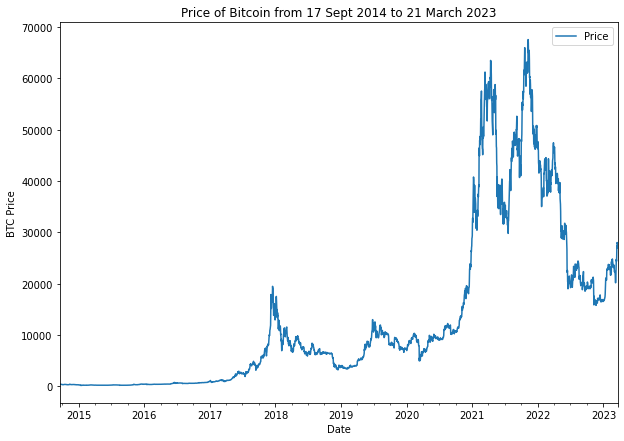

In [9]:
# let's plot everything
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.legend()
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

### Importing time series data with Python's CSV module

In [10]:
import csv
from datetime import datetime

timesteps = []
btc_price = []

with open("/content/BTC-USD.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[0], "%Y-%m-%d")) # get the dates as dates
    btc_price.append(float(line[5])) # get the adjusted closing price

# view first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2014, 9, 17, 0, 0),
  datetime.datetime(2014, 9, 18, 0, 0),
  datetime.datetime(2014, 9, 19, 0, 0),
  datetime.datetime(2014, 9, 20, 0, 0),
  datetime.datetime(2014, 9, 21, 0, 0),
  datetime.datetime(2014, 9, 22, 0, 0),
  datetime.datetime(2014, 9, 23, 0, 0),
  datetime.datetime(2014, 9, 24, 0, 0),
  datetime.datetime(2014, 9, 25, 0, 0),
  datetime.datetime(2014, 9, 26, 0, 0)],
 [457.334015,
  424.440002,
  394.79599,
  408.903992,
  398.821014,
  402.152008,
  435.790985,
  423.204987,
  411.574005,
  404.424988])

Let's plot this

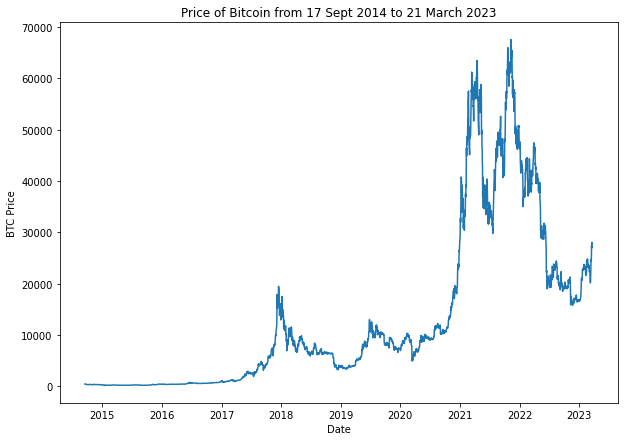

In [11]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.title("Price of Bitcoin from 17 Sept 2014 to 21 March 2023");

## Format Data Part 1 : Create train and test sets for Time Series data

Before we create splits we want to know what kind of data we have.

In time series problems, you'll either have **univariate** and **multivariate** data.

- Univariate time series data deals with one variable, for example using the price of bitcoin to predict the price of bitcoin
- Multivariate time series data deals with more than one variable, for example predicting the price of bitcoin using the price of bitcoin and block rewards and volume

### Create Train and Test sets for time series (wrong way)


In [12]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)


X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2486,), (622,), (2486,), (622,))

Looks like the splits worked well, but let's not trust numbers on a page, visualize, visualize and visualize

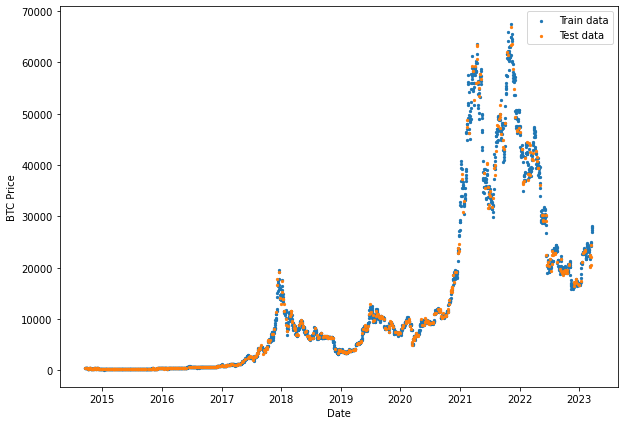

In [13]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend();

Since this is a time component so the split should be continous, if there is no time component then random split will work but since we are going to forecast the future, then we need past data.

### Create Train and Test sets for time series (the right way)

In [14]:
split_size = int(0.8 * len(prices)) # 80% of train sets and 20% of test sets

X_train, y_train = timesteps[:split_size], prices[:split_size]
X_test, y_test = timesteps[split_size:], prices[split_size:]



Now if we visualize the plot,

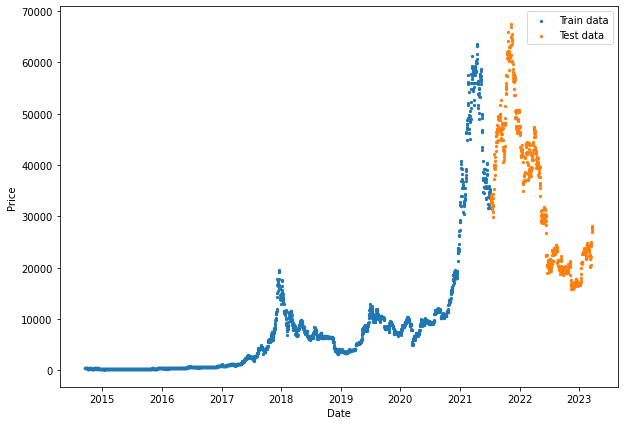

In [15]:
plt.figure(figsize=(10,7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend();

This is the correct way of splitting the data of time series problem. The plot should look like above.

### Creating a plotting function

Rather than retyping `matplotlib` commands to continously plot data, let's make a plotting function we can reuse later

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a time series plot on timesteps (a series of points in time) against values
  (a series of values across timesteps)

  Parameters
  ------------
  timesteps: array of timesteps
  values: array of values across time
  format: style of plot, default '.'
  start: where to start the plot
  end: where to end the plot
  label: label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

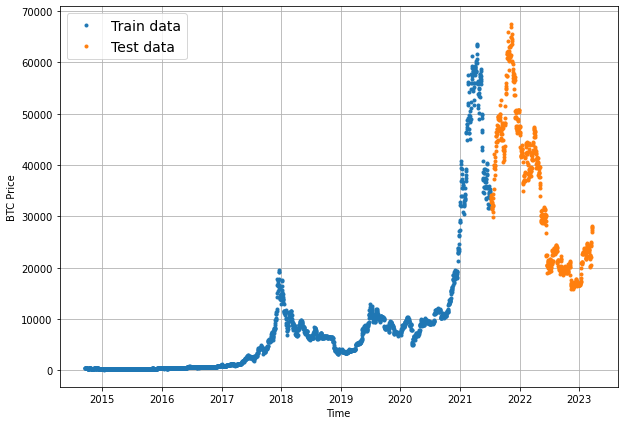

In [17]:
plt.figure(figsize=(10,7))
plot_time_series(X_train, y_train, label="Train data")
plot_time_series(X_test, y_test, label="Test data")

## Modelling Experiments

There are two terms that we should be familiar with, **horizon** and **window**,
- **horizon**: number of timesteps to predict into future
- **window**: number of timesteps from past used to predict **horizon**

For example, if we wanted to predict the price of Bitcoin for Tomorrow (1 day in the future) using the previous week's worth of Bitcoin prices (7 days in the past), the horizon would be 1 and window would be 7.


List of modelling experiments we are going to perform,


| **Model Number** | **Model Type** | **Horizon Size** | **Window Size** | **Extra data** |
|-------------|--------------|------------|------------|------------|
| 0 | Naive forecast (baseline) | NA | NA | NA |
| 1 | Dense model | 1 | 7 | NA |
| 2 | Same as 1 | 1 | 30 | NA |
| 3 | same as 1 | 7 | 30 | NA |
| 4 | Conv1D | 1 | 7 | NA |
| 5 | LSTM | 1 | 7 | NA |
| 6 | same as 1 (but with univariate) | 1 | 7 | Block reward size/Volume |
| 7 | [N-Beats Algorithm](https://arxiv.org/pdf/1905.10437.pdf) | 1 | 7 | NA |
| 8 | Ensemble (multiple models optimized on different loss functions) | 1 | 7 | NA |
| 9 | Future prediction model (model to predict future values) | 1 | 7 | NA |
| 10 | Same as 1 (but with turkey 🦃 data introduced) | 1 | 7 | NA |

## Model 0 : Naive forecast (baseline)

One of the most common baseline models for time series forecasting is naive model, (also called the naive forecast), requires no training at all.

That's because all the naive model does is use the previous timestep value to predict the next timestep value.

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:

> The prediction at timestep `t`(y-hat) is equal to the value at timestep `t-1`(the previous timestep)

In an open system (like a stock market or crypto market), you'll often find beating the naive forecast with any kind of model is quite hard.

> 🔑 **Note**: an **open system** is a system where inputs and outputs can freely flow, such as market (stock or crypto), whereas a **closed system** the inputs and outputs are contained within the system (like a poker game with friends, as we know the buy in and how much the winner can get). Time series forecasting in **open systems** is generally quite poor.

In [18]:
# create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:] # view first and last 10

(array([32877.371094, 33798.011719, 33520.519531, 34240.1875  ,
        33155.847656, 32702.025391, 32822.347656, 31780.730469,
        31421.539063, 31533.068359]),
 array([20632.410156, 22163.949219, 24197.533203, 24746.074219,
        24375.960938, 25052.789063, 27423.929688, 26965.878906,
        28038.675781, 27767.236328]))

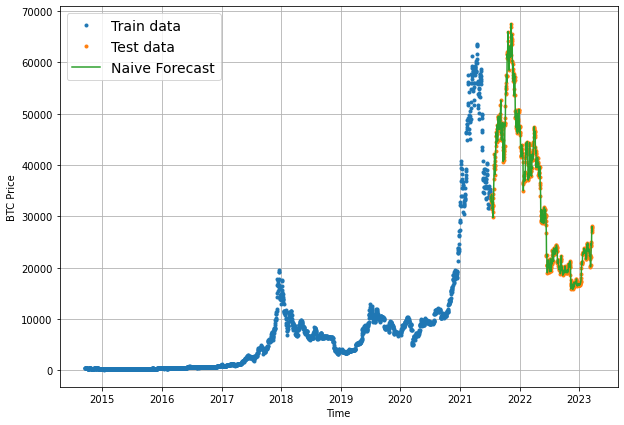

In [19]:
# plot the naive forecast
plt.figure(figsize=(10,7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive Forecast");

Let's zoom it and only plot the test and naive forecast


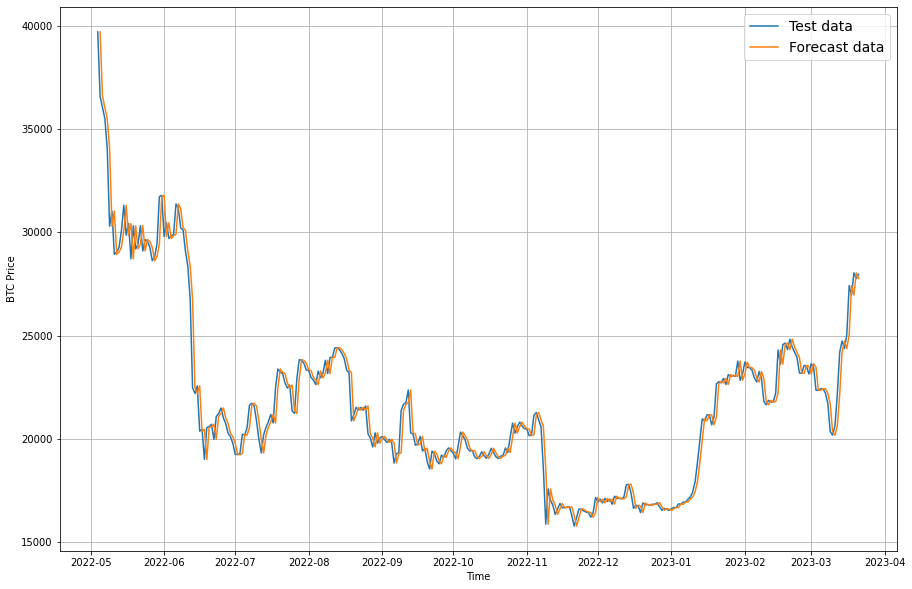

In [20]:
plt.figure(figsize=(15,10))
offset=300
plot_time_series(timesteps=X_test, values=y_test, start=offset, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format="-", label="Forecast data");

When we zoom in we see the naive forecast comes slightly after the test data. This makes sense because the naive forecast uses the previous timestep value to predict the next timestep value.

Forecast made. Time to evaluate it.

## Evaluating a Time series model

Time series problem is often involves predicting a number which is the same output as Regression model, so we can similar types of metrics to evaluate Time series model, but let's see what are they, but thing to note for all the metrics, **lower the better** (for example an MAE of 0 is better than MAE 100).

### Scale Dependent Errors

These are metrics which can be used to compare time series values and forecasts which are in same scale.

for example, predicting the price of Bitcoin using historical prices in USD versus forecasting values in USD

| Metric | Details | Code |
| ------ |------ |------ |
| MAE (mean absolute error) |Easy to interpret (a forecast is X amount different from actual amount). Forecast methods which minimises the MAE will lead to forecasts of the median | `tf.keras.metrics.mean_absolute_error()` |
| RMSE (root mean squared error) | Forecasts which minimises the RMSE lead to forecasts of the mean | `tf.sqrt(tf.keras.metrics.mean_square_error())` |

### Percentage Errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MAPE (mean absolute percentage error) | Most commonly used precentage error. May explode (not work) if `y=0` | `tf.keras.metrics.mean_absolute_percentage_error()` |
| sMAPE (symmetric mean absolute percentage error) | Recommended not to be used by [Forecasting: Principles and Practice](https://otexts.com/fpp3/accuracy.html#percentage-errors), though it is used in forecasting competitions | Custom implementation |


### Scaled Errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

| Metric | Details | Code |
| ---- | ---- | ---- |
| MASE (mean absolute scaled error) | MASE equals one of the naive forecast (or very close to one). A forecast which performs better than the naive should get < 1 MASE | See sktime's, [`mase_loss`](https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16) |


### Creating our own MASE function

We'll take inspiration from [sktime's](https://github.com/alan-turing-institute/sktime)(Scikit-Learn for time series) `MeanAbsoluteScaledError` class which calculates the MASE.
                                                                                                                          
                                                                                                                                                                                                                                                    


In [21]:
import tensorflow as tf

In [22]:
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true, y_pred))

  naive_mae_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:], y_true[:-1]))

  return mae / naive_mae_no_seasonality

Let's put each of our different evaluation metrics together into a function.

In [23]:
def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_test[1:],
                               naive_forecast)

naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Alright, this will be our baseline results to beat in further modelling experiment.

So if we look into `mae` result, it's `807.27` it means that each prediction in the naive forecast is off by **$807**

## Other kinds of time series forecasting models which can be used for baselines and actual forecasts

| Model/Library Name |	Resource |
| ---- | ---- |
| Moving average |	https://machinelearningmastery.com/ moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) |	https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) |	https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) |	https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) |	https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) |	https://github.com/linkedin/greykite |

## Format Data Part 2: Windowing dataset

We've got to window our time series.

Why do we window ?

Windowing is a method to turn a time series dataset into **supervised learning problem.**

In other words, we want to use windows of the past to predict the future.

For example, for a univariate time series, windowing for one week (window=7) to predict the next single value(horizon=1) might look like:

```
Window for one week (univariate time series)

[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

Similarly the price of Bitcoin look like,

```
Window for one week with the target of predicting the next day (Bitcoin prices)

[123.654, 125.455, 108.584, 118.674, 121.338, 120.655, 121.795] -> [123.033]
[125.455, 108.584, 118.674, 121.338, 120.655, 121.795, 123.033] -> [124.049]
[108.584, 118.674, 121.338, 120.655, 121.795, 123.033, 124.049] -> [125.961]
```

Let's build some functions which take in a univariate time series and turn it into windows and horizons of specified sizes.

We'll start with the default horizon size of 1 and a window size of 7 (these aren't necessarily the best values to use, these are just randomly picked)

In [25]:
HORIZON = 1
WINDOW_SIZE = 7

In [26]:
# Create a function which takes an array as input and return it in form of window and horizon
def get_labelled_windows(x, horizon=1):
  """
  Create labels for windowed dataset

  E.g if horizon=1 (default)
  Input: [1, 2, 3, 4, 5, 6, 7] -> Output: ([1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [27]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)

print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [1 2 3 4 5 6 7] -> Label: 8


Now we can do the same thing with entire time series data through Python loops, but to make things faster we can use [Numpy's array indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html).


Let's write a function which:

1. Creates a window step of specific window size, for example: `[[0, 1, 2, 3, 4, 5, 6, 7]]`
2. Uses Numpy indexing to create a 2D of multiple window steps, for example:

```
[0, 1, 2, 3, 4, 5, 6]
[1, 2, 3, 4, 5, 6, 7]
[2, 3, 4, 5, 6, 7, 8]
```
3. Uses the 2D array of multiple window steps to index on a target series.
4. Uses the `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon.




In [28]:
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """

  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  #print(f"window_step: \n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T
  #print(f"Window indexes: \n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

Let's try with bitcoin prices

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3101, 3101)

In [30]:
# View the first 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]} ")

Window: [457.334015 424.440002 394.79599  408.903992 398.821014 402.152008
 435.790985] -> Label: [423.204987] 
Window: [424.440002 394.79599  408.903992 398.821014 402.152008 435.790985
 423.204987] -> Label: [411.574005] 
Window: [394.79599  408.903992 398.821014 402.152008 435.790985 423.204987
 411.574005] -> Label: [404.424988] 


In [31]:
# View the last 3 windows/labels
for i in range(3):
  print(f"Window: {full_windows[i-3]} -> Label: {full_labels[i-3]} ")

Window: [22163.949219 24197.533203 24746.074219 24375.960938 25052.789063
 27423.929688 26965.878906] -> Label: [28038.675781] 
Window: [24197.533203 24746.074219 24375.960938 25052.789063 27423.929688
 26965.878906 28038.675781] -> Label: [27767.236328] 
Window: [24746.074219 24375.960938 25052.789063 27423.929688 26965.878906
 28038.675781 27767.236328] -> Label: [27964.888672] 


Anyways, we have written the whole function but this can also be achieved using [tf.keras.preprocessing.timeseries_dataset_from_array()](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array)

### Turning windows into Training and Test sets



In [32]:
# Make the train and test split
def make_train_test_split(windows, labels, test_split=0.2):

  split_size=int(len(windows) * (1-test_split)) # this will be default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [33]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2480, 621, 2480, 621)

In [34]:
train_windows[:5], train_labels[:5]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987],
        [394.79599 , 408.903992, 398.821014, 402.152008, 435.790985,
         423.204987, 411.574005],
        [408.903992, 398.821014, 402.152008, 435.790985, 423.204987,
         411.574005, 404.424988],
        [398.821014, 402.152008, 435.790985, 423.204987, 411.574005,
         404.424988, 399.519989]]), array([[423.204987],
        [411.574005],
        [404.424988],
        [399.519989],
        [377.181   ]]))

## Creating a Model Checkpoint

For a fair comparison between all the models that we're going to build, we need to train it with equal amount of epochs let's say 100 and then store the best performing model during training so that we can compare with the best performing model.

This can be possible using `ModelCheckpoint`.

`ModelCheckpoint` callback will monitor our model's performance during training and save the best model to the file by setting `save_best_only=True`


In [35]:
import os

def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor='val_loss',
                                            verbose=0,
                                            save_best_only=True)

## Model 1: Dense model (window=7, horizon=1)

We're going to start by keeping it simple, `model_1` will have:
- A single dense layer with 128 hidden units and reLu activation
- An output layer with linear activation
- Adam optimizer and MAE, MSE metrics
- Batch size of 128

In [36]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(17)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], name='model_1_dense')


# compile the model
model_1.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae'])

# fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
12/20 [=================>............] - ETA: 0s - loss: 775.1735 - mae: 775.1735   

20/20 [==============================] - 4s 138ms/step - loss: 726.8607 - mae: 726.8607 - val_loss: 1579.0851 - val_mae: 1579.0851
Epoch 2/100
20/20 [==============================] - 0s 14ms/step - loss: 497.5992 - mae: 497.5992 - val_loss: 1733.1877 - val_mae: 1733.1877
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 443.7523 - mae: 443.7523

20/20 [==============================] - 1s 67ms/step - loss: 448.2230 - mae: 448.2230 - val_loss: 1388.6797 - val_mae: 1388.6797
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 421.7811 - mae: 421.7811 - val_loss: 1490.3925 - val_mae: 1490.3925
Epoch 5/100
18/20 [==========================>...] - ETA: 0s - loss: 416.4227 - mae: 416.4227

20/20 [==============================] - 1s 62ms/step - loss: 412.7359 - mae: 412.7359 - val_loss: 1265.8080 - val_mae: 1265.8080
Epoch 6/100
17/20 [========================>.....] - ETA: 0s - loss: 394.8489 - mae: 394.8489

20/20 [==============================] - 1s 69ms/step - loss: 390.0898 - mae: 390.0898 - val_loss: 1218.2083 - val_mae: 1218.2083
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 372.2375 - mae: 372.2375 - val_loss: 1351.6401 - val_mae: 1351.6401
Epoch 8/100
19/20 [===========================>..] - ETA: 0s - loss: 349.6021 - mae: 349.6021

20/20 [==============================] - 1s 50ms/step - loss: 351.4123 - mae: 351.4123 - val_loss: 1101.5803 - val_mae: 1101.5803
Epoch 9/100
15/20 [=====================>........] - ETA: 0s - loss: 334.5928 - mae: 334.5928

20/20 [==============================] - 1s 47ms/step - loss: 343.1332 - mae: 343.1332 - val_loss: 1057.6531 - val_mae: 1057.6531
Epoch 10/100
 1/20 [>.............................] - ETA: 0s - loss: 306.3096 - mae: 306.3096

20/20 [==============================] - 1s 57ms/step - loss: 317.3036 - mae: 317.3036 - val_loss: 1032.4740 - val_mae: 1032.4740
Epoch 11/100
13/20 [==================>...........] - ETA: 0s - loss: 326.4926 - mae: 326.4926

20/20 [==============================] - 1s 46ms/step - loss: 324.9240 - mae: 324.9240 - val_loss: 970.8895 - val_mae: 970.8895
Epoch 12/100
17/20 [========================>.....] - ETA: 0s - loss: 297.8319 - mae: 297.8319

20/20 [==============================] - 1s 70ms/step - loss: 292.7170 - mae: 292.7170 - val_loss: 929.9190 - val_mae: 929.9190
Epoch 13/100
14/20 [====================>.........] - ETA: 0s - loss: 307.2226 - mae: 307.2226

20/20 [==============================] - 1s 71ms/step - loss: 293.0746 - mae: 293.0746 - val_loss: 906.8612 - val_mae: 906.8612
Epoch 14/100
20/20 [==============================] - 0s 15ms/step - loss: 282.0942 - mae: 282.0942 - val_loss: 952.6690 - val_mae: 952.6690
Epoch 15/100
19/20 [===========================>..] - ETA: 0s - loss: 274.7537 - mae: 274.7537

20/20 [==============================] - 2s 121ms/step - loss: 276.5682 - mae: 276.5682 - val_loss: 903.3663 - val_mae: 903.3663
Epoch 16/100
16/20 [=======================>......] - ETA: 0s - loss: 284.5675 - mae: 284.5675

20/20 [==============================] - 1s 62ms/step - loss: 279.8287 - mae: 279.8287 - val_loss: 876.5587 - val_mae: 876.5587
Epoch 17/100
20/20 [==============================] - 0s 9ms/step - loss: 280.3974 - mae: 280.3974 - val_loss: 1058.2787 - val_mae: 1058.2787
Epoch 18/100
20/20 [==============================] - 0s 16ms/step - loss: 293.9345 - mae: 293.9345 - val_loss: 1022.3723 - val_mae: 1022.3723
Epoch 19/100
20/20 [==============================] - 0s 7ms/step - loss: 283.3453 - mae: 283.3453 - val_loss: 882.3300 - val_mae: 882.3300
Epoch 20/100
20/20 [==============================] - 0s 4ms/step - loss: 265.2776 - mae: 265.2776 - val_loss: 963.3951 - val_mae: 963.3951
Epoch 21/100
 1/20 [>.............................] - ETA: 0s - loss: 282.5546 - mae: 282.5546

20/20 [==============================] - 2s 107ms/step - loss: 264.6294 - mae: 264.6294 - val_loss: 872.4861 - val_mae: 872.4861
Epoch 22/100
20/20 [==============================] - 0s 11ms/step - loss: 270.3319 - mae: 270.3319 - val_loss: 886.7861 - val_mae: 886.7861
Epoch 23/100
20/20 [==============================] - 0s 12ms/step - loss: 266.3811 - mae: 266.3811 - val_loss: 897.8063 - val_mae: 897.8063
Epoch 24/100
20/20 [==============================] - 0s 8ms/step - loss: 270.0252 - mae: 270.0252 - val_loss: 984.5334 - val_mae: 984.5334
Epoch 25/100
20/20 [==============================] - ETA: 0s - loss: 282.7102 - mae: 282.7102

20/20 [==============================] - 1s 49ms/step - loss: 282.7102 - mae: 282.7102 - val_loss: 854.1116 - val_mae: 854.1116
Epoch 26/100
20/20 [==============================] - 0s 6ms/step - loss: 253.2096 - mae: 253.2096 - val_loss: 944.0311 - val_mae: 944.0311
Epoch 27/100
 1/20 [>.............................] - ETA: 0s - loss: 265.3788 - mae: 265.3788

20/20 [==============================] - 1s 48ms/step - loss: 264.6739 - mae: 264.6739 - val_loss: 853.3840 - val_mae: 853.3840
Epoch 28/100
20/20 [==============================] - 0s 10ms/step - loss: 254.1138 - mae: 254.1138 - val_loss: 887.7969 - val_mae: 887.7969
Epoch 29/100
 1/20 [>.............................] - ETA: 0s - loss: 311.3080 - mae: 311.3080

20/20 [==============================] - 1s 50ms/step - loss: 262.4544 - mae: 262.4544 - val_loss: 843.5315 - val_mae: 843.5315
Epoch 30/100
20/20 [==============================] - 0s 11ms/step - loss: 262.3380 - mae: 262.3380 - val_loss: 851.9478 - val_mae: 851.9478
Epoch 31/100
20/20 [==============================] - 0s 6ms/step - loss: 260.5388 - mae: 260.5388 - val_loss: 859.2596 - val_mae: 859.2596
Epoch 32/100
20/20 [==============================] - 0s 5ms/step - loss: 256.0082 - mae: 256.0082 - val_loss: 883.4543 - val_mae: 883.4543
Epoch 33/100
20/20 [==============================] - 0s 7ms/step - loss: 266.1675 - mae: 266.1675 - val_loss: 862.8215 - val_mae: 862.8215
Epoch 34/100
20/20 [==============================] - 0s 13ms/step - loss: 256.4621 - mae: 256.4621 - val_loss: 924.5150 - val_mae: 924.5150
Epoch 35/100
20/20 [==============================] - 0s 18ms/step - loss: 264.8565 - mae: 264.8565 - val_loss: 1134.2755 - val_mae: 1134.2755
Epoch 36/100
10/20 [=======

20/20 [==============================] - 1s 75ms/step - loss: 280.8658 - mae: 280.8658 - val_loss: 836.3482 - val_mae: 836.3482
Epoch 37/100
20/20 [==============================] - 0s 19ms/step - loss: 277.4103 - mae: 277.4103 - val_loss: 863.1399 - val_mae: 863.1399
Epoch 38/100
20/20 [==============================] - 0s 6ms/step - loss: 258.5453 - mae: 258.5453 - val_loss: 877.2026 - val_mae: 877.2026
Epoch 39/100
20/20 [==============================] - 0s 7ms/step - loss: 249.3313 - mae: 249.3313 - val_loss: 839.3601 - val_mae: 839.3601
Epoch 40/100
20/20 [==============================] - 0s 14ms/step - loss: 265.0627 - mae: 265.0627 - val_loss: 839.0272 - val_mae: 839.0272
Epoch 41/100
20/20 [==============================] - 0s 12ms/step - loss: 261.7078 - mae: 261.7078 - val_loss: 854.9076 - val_mae: 854.9076
Epoch 42/100
20/20 [==============================] - 0s 6ms/step - loss: 261.2977 - mae: 261.2977 - val_loss: 986.6207 - val_mae: 986.6207
Epoch 43/100
19/20 [=========

20/20 [==============================] - 1s 60ms/step - loss: 263.4520 - mae: 263.4520 - val_loss: 833.9953 - val_mae: 833.9953
Epoch 44/100
20/20 [==============================] - 0s 4ms/step - loss: 256.1074 - mae: 256.1074 - val_loss: 1032.0223 - val_mae: 1032.0223
Epoch 45/100
 1/20 [>.............................] - ETA: 0s - loss: 282.3845 - mae: 282.3845

20/20 [==============================] - 1s 68ms/step - loss: 271.7437 - mae: 271.7437 - val_loss: 828.9094 - val_mae: 828.9094
Epoch 46/100
20/20 [==============================] - 0s 9ms/step - loss: 254.7035 - mae: 254.7035 - val_loss: 882.0366 - val_mae: 882.0366
Epoch 47/100
20/20 [==============================] - 0s 8ms/step - loss: 258.0092 - mae: 258.0092 - val_loss: 829.1947 - val_mae: 829.1947
Epoch 48/100
20/20 [==============================] - 0s 9ms/step - loss: 250.2232 - mae: 250.2232 - val_loss: 831.6000 - val_mae: 831.6000
Epoch 49/100
11/20 [===============>..............] - ETA: 0s - loss: 240.9367 - mae: 240.9367

20/20 [==============================] - 1s 53ms/step - loss: 255.5880 - mae: 255.5880 - val_loss: 824.0400 - val_mae: 824.0400
Epoch 50/100
20/20 [==============================] - 0s 8ms/step - loss: 250.4670 - mae: 250.4670 - val_loss: 844.3308 - val_mae: 844.3308
Epoch 51/100
20/20 [==============================] - 0s 10ms/step - loss: 249.2952 - mae: 249.2952 - val_loss: 826.9600 - val_mae: 826.9600
Epoch 52/100
20/20 [==============================] - 0s 13ms/step - loss: 252.7762 - mae: 252.7762 - val_loss: 898.6885 - val_mae: 898.6885
Epoch 53/100
20/20 [==============================] - 0s 9ms/step - loss: 256.6427 - mae: 256.6427 - val_loss: 826.5491 - val_mae: 826.5491
Epoch 54/100
20/20 [==============================] - 0s 7ms/step - loss: 257.0478 - mae: 257.0478 - val_loss: 828.4357 - val_mae: 828.4357
Epoch 55/100
20/20 [==============================] - 0s 6ms/step - loss: 270.7476 - mae: 270.7476 - val_loss: 899.4622 - val_mae: 899.4622
Epoch 56/100
20/20 [==========

20/20 [==============================] - 1s 44ms/step - loss: 254.6142 - mae: 254.6142 - val_loss: 822.4050 - val_mae: 822.4050
Epoch 69/100
20/20 [==============================] - 0s 4ms/step - loss: 254.7339 - mae: 254.7339 - val_loss: 925.6094 - val_mae: 925.6094
Epoch 70/100
20/20 [==============================] - 0s 13ms/step - loss: 261.9818 - mae: 261.9818 - val_loss: 823.9061 - val_mae: 823.9061
Epoch 71/100
20/20 [==============================] - 0s 9ms/step - loss: 250.4254 - mae: 250.4254 - val_loss: 844.6056 - val_mae: 844.6056
Epoch 72/100
20/20 [==============================] - 0s 4ms/step - loss: 257.8318 - mae: 257.8318 - val_loss: 1226.0521 - val_mae: 1226.0521
Epoch 73/100
20/20 [==============================] - 0s 5ms/step - loss: 288.4019 - mae: 288.4019 - val_loss: 919.7183 - val_mae: 919.7183
Epoch 74/100
20/20 [==============================] - 0s 17ms/step - loss: 249.5554 - mae: 249.5554 - val_loss: 862.4362 - val_mae: 862.4362
Epoch 75/100
20/20 [========

20/20 [==============================] - 1s 48ms/step - loss: 250.5308 - mae: 250.5308 - val_loss: 820.6391 - val_mae: 820.6391
Epoch 80/100
20/20 [==============================] - 0s 7ms/step - loss: 258.4687 - mae: 258.4687 - val_loss: 848.9853 - val_mae: 848.9853
Epoch 81/100
20/20 [==============================] - 0s 11ms/step - loss: 251.4035 - mae: 251.4035 - val_loss: 820.6687 - val_mae: 820.6687
Epoch 82/100
20/20 [==============================] - 0s 7ms/step - loss: 271.8557 - mae: 271.8557 - val_loss: 1093.6079 - val_mae: 1093.6079
Epoch 83/100
20/20 [==============================] - 0s 12ms/step - loss: 284.2540 - mae: 284.2540 - val_loss: 1114.0153 - val_mae: 1114.0153
Epoch 84/100
20/20 [==============================] - 0s 15ms/step - loss: 303.1770 - mae: 303.1770 - val_loss: 916.5914 - val_mae: 916.5914
Epoch 85/100
20/20 [==============================] - 0s 15ms/step - loss: 281.5408 - mae: 281.5408 - val_loss: 890.7911 - val_mae: 890.7911
Epoch 86/100
20/20 [====

20/20 [==============================] - 1s 75ms/step - loss: 254.3240 - mae: 254.3240 - val_loss: 817.9070 - val_mae: 817.9070
Epoch 88/100
20/20 [==============================] - 0s 12ms/step - loss: 249.4521 - mae: 249.4521 - val_loss: 842.6160 - val_mae: 842.6160
Epoch 89/100
20/20 [==============================] - 0s 9ms/step - loss: 253.7507 - mae: 253.7507 - val_loss: 842.1527 - val_mae: 842.1527
Epoch 90/100
20/20 [==============================] - 0s 5ms/step - loss: 249.6943 - mae: 249.6943 - val_loss: 1094.7778 - val_mae: 1094.7778
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 262.3688 - mae: 262.3688 - val_loss: 818.9326 - val_mae: 818.9326
Epoch 92/100
20/20 [==============================] - 0s 5ms/step - loss: 259.6039 - mae: 259.6039 - val_loss: 872.1128 - val_mae: 872.1128
Epoch 93/100
20/20 [==============================] - 0s 7ms/step - loss: 272.6897 - mae: 272.6897 - val_loss: 836.3852 - val_mae: 836.3852
Epoch 94/100
20/20 [=========

In [37]:
# evaluate the model
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 828.6636 - mae: 828.6636


[828.66357421875, 828.66357421875]

This is the last epoch's evaluation results, but let's check the best model weights

In [38]:
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense')
model_1.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 817.9072 - mae: 817.9072


[817.9071655273438, 817.9071655273438]

Okay, not bad but what about the predictions on `model_1`. Let's create a function to make predictions and then evaluate the results of model_1 on those predictions.

### Make Prediction function

In [39]:
def make_predictions(model, input_data):
  """
  Returns the prediction result on input_data for the model passed.
  """
  y_preds = model.predict(input_data)
  return tf.squeeze(y_preds) # returns 1D array of predictions

In [40]:
model_1_preds = make_predictions(model_1, test_windows)
model_1_preds[:10]

20/20 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([33018.23 , 33777.758, 33512.234, 34211.758, 33338.457, 32692.186,
       32917.41 , 31876.37 , 31509.229, 31490.535], dtype=float32)>

In [41]:
test_labels.shape, model_1_preds.shape

((621, 1), TensorShape([621]))

In [42]:
# evaluate results
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 817.9072,
 'mse': 1514065.0,
 'rmse': 1230.4735,
 'mape': 2.3698328,
 'mase': 1.0000142}

In [43]:
# view the naive results
naive_results

{'mae': 807.27057,
 'mse': 1472736.0,
 'rmse': 1213.5634,
 'mape': 2.3311722,
 'mase': 1.0000142}

Naive model results (baseline) is beating our first dense model(model_1) but that's expected. Let's do further visualization by plotting the prediction in the graph.

### Plot `model_1` results

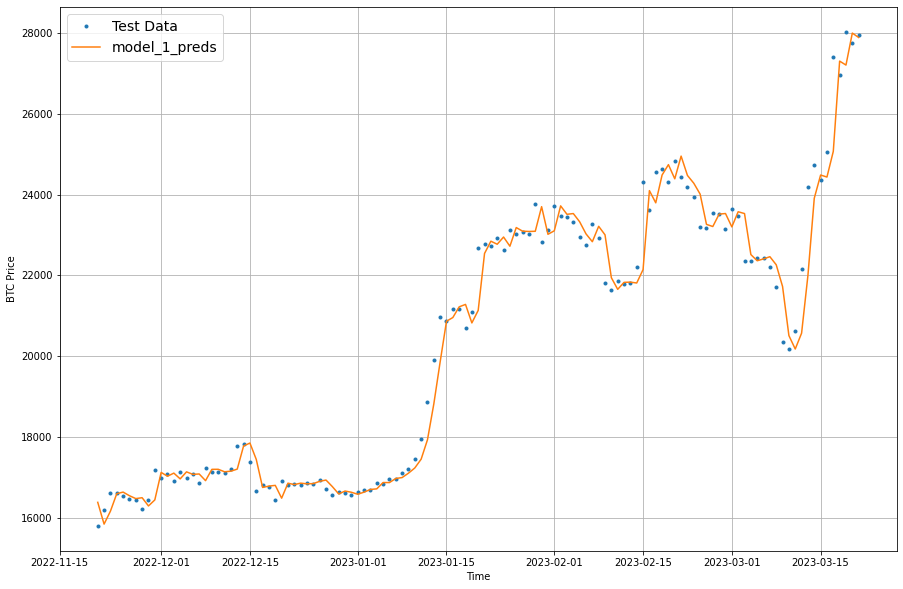

In [44]:
offset = 500
plt.figure(figsize=(15, 10))
plot_time_series(timesteps=X_test[-len(test_windows):],values=test_labels[:, 0], start=offset, label="Test Data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-",label="model_1_preds")

Something wrong with the predictions ? 

And also predictions are little behind the actual values. For more about this, [Read Autocorrelation](https://otexts.com/fpp3/acf.html)

Since they're on the test dataset. So they're not actual forecasts that we are trying for predicting a price.

With our current model setup, we've to make forecasts for the future.

## Model 2: Dense (window=30, horizon=1)

In this model we are going to predict on window_size 30, that is past 30 days of bitcoin prices to predict next day of bitcoin price.

In [45]:
HORIZON=1
WINDOW_SIZE=30

In [48]:
# Reset the windows and labels with 30 day prices of bitcoin
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
full_windows[:2], full_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996],
        [391.441986]]))

In [49]:
# Create train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2462, 616, 2462, 616)

In [50]:
# Now ready to create our dense model

tf.random.set_seed(17)

# Create the model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON, activation='linear')
], 'model_2_dense')

# compile the model
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [51]:
# evaluate the model with the last epochs 
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 4ms/step - loss: 1427.5585


1427.5584716796875

In [53]:
# Evaluation on the best model
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense/')
model_2.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 891.3235


891.3235473632812

In [54]:
# prediction on model_2
model_2_preds = make_predictions(model_2, test_windows)

# evaluate the results
model_2_results = evaluate_preds(tf.squeeze(test_labels), model_2_preds)
model_2_results

20/20 [==============================] - 0s 2ms/step


{'mae': 891.32367,
 'mse': 1770381.2,
 'rmse': 1330.5568,
 'mape': 2.564526,
 'mase': 0.99996686}

In [55]:
model_1_results

{'mae': 817.9072,
 'mse': 1514065.0,
 'rmse': 1230.4735,
 'mape': 2.3698328,
 'mase': 1.0000142}

It looks like `model_1` performs better than `model_2`.

Also, smaller windows size is performing better so in that case we can create window size of something like 5 days.



How do the predictions look ?

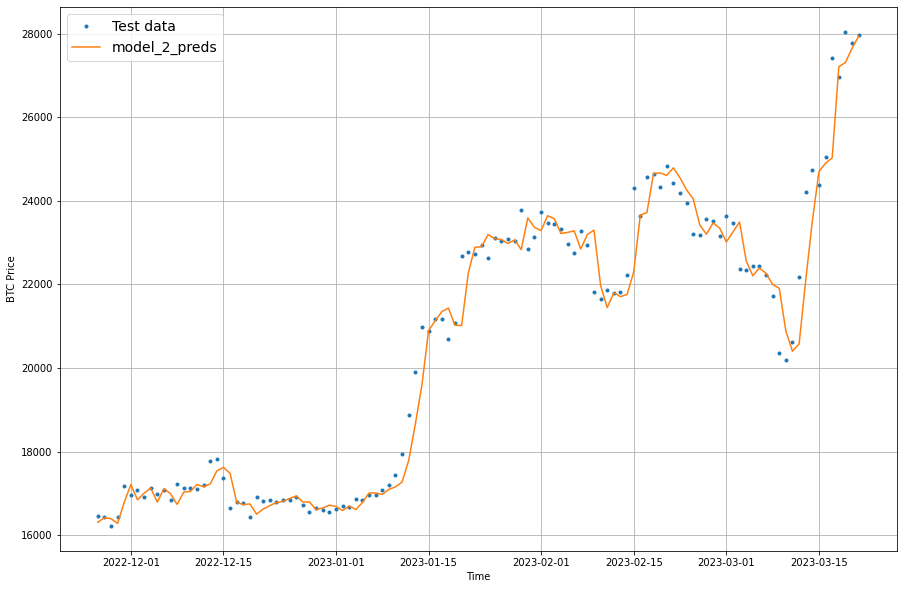

In [56]:
offset = 500
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds")

## Model 3 : Dense(window=30, horizon=7)

In [57]:
HORIZON=7
WINDOW_SIZE=30

# create windows and labels
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train and test split
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)

train_windows[:2], train_labels[:2]

(array([[457.334015, 424.440002, 394.79599 , 408.903992, 398.821014,
         402.152008, 435.790985, 423.204987, 411.574005, 404.424988,
         399.519989, 377.181   , 375.46701 , 386.944   , 383.61499 ,
         375.071991, 359.511993, 328.865997, 320.51001 , 330.07901 ,
         336.187012, 352.940002, 365.026001, 361.562012, 362.299011,
         378.549011, 390.414001, 400.869995, 394.77301 , 382.556   ],
        [424.440002, 394.79599 , 408.903992, 398.821014, 402.152008,
         435.790985, 423.204987, 411.574005, 404.424988, 399.519989,
         377.181   , 375.46701 , 386.944   , 383.61499 , 375.071991,
         359.511993, 328.865997, 320.51001 , 330.07901 , 336.187012,
         352.940002, 365.026001, 361.562012, 362.299011, 378.549011,
         390.414001, 400.869995, 394.77301 , 382.556   , 383.757996]]),
 array([[383.757996, 391.441986, 389.54599 , 382.845001, 386.475006,
         383.15799 , 358.416992],
        [391.441986, 389.54599 , 382.845001, 386.475006, 383.1579

In [58]:
len(train_windows), len(test_windows)

(2457, 615)

In [59]:
tf.random.set_seed(17)

# Create Model
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_3_dense')

# Compile
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam())

# Fit 
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [60]:
# evaluation on last epoch
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 2ms/step - loss: 1789.6892


1789.689208984375

In [61]:
# load the best model and evaluate
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense/')
model_3.evaluate(test_windows, test_labels)

20/20 [==============================] - 0s 3ms/step - loss: 1736.2817


1736.28173828125

This is going to be large because we are trying to predict 7 days in advance, for example we want to predict the weather in advance of 7 days. So there will be higher chances of wrong predictibility.

In [63]:
# Make prediction and see the results
model_3_preds = make_predictions(model_3, test_windows)

20/20 [==============================] - 0s 3ms/step


In [68]:
model_3_preds.shape, test_labels.shape

(TensorShape([615, 7]), (615, 7))

In [65]:
# view the results
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': array([ 572.9001  ,  634.1696  , 1483.7311  , 2498.147   ,  925.0374  ,
        1268.5345  ,  912.59094 ,  852.71454 , 1224.0614  , 1419.2283  ,
        2285.8323  , 3379.895   , 4290.6465  , 5077.8135  , 5529.5635  ,
        5402.952   , 5407.5913  , 4775.582   , 3828.8489  , 1639.1155  ,
         805.1864  , 1173.4001  , 1881.9642  , 2249.0989  , 2012.5419  ,
        3054.6597  , 4559.952   , 4790.017   , 4529.9917  , 3088.3972  ,
        1824.2852  , 2046.4481  , 1274.8025  , 1130.4174  ,  885.3761  ,
        1739.0234  , 1254.2014  , 1388.9425  , 1738.6624  , 1994.3995  ,
        2776.841   , 3242.9146  , 2694.2048  ,  753.16797 , 1089.0703  ,
        1811.1595  , 2143.25    , 1476.717   , 1132.5123  , 1174.2483  ,
        1018.11163 ,  919.9894  , 1755.346   , 2071.0747  , 2995.8086  ,
        2188.1355  , 2228.7583  , 2824.2617  , 3479.0933  , 5277.0874  ,
        6921.1714  , 3240.9353  , 1558.5491  , 1275.2662  , 1339.6072  ,
        2472.2583  , 2298.0034  , 2593.274  

This is multi-dimensional output because the predictions are getting evaluated across the HORIZON timesteps (7 predictions at a time).

To fix this we need to adjust our `evaluate_preds()` function.

In [71]:
tf.reduce_mean(model_3_results['mae'])

<tf.Tensor: shape=(), dtype=float32, numpy=1736.2817>

In [72]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate the metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # If horizon is greater than 1
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

Let's evaulate our `model_3` now

In [73]:
model_3_results = evaluate_preds(test_labels, model_3_preds)
model_3_results

{'mae': 1736.2817,
 'mse': 6408758.5,
 'rmse': 1994.5815,
 'mape': 5.1271167,
 'mase': 0.99998134}

In [74]:
model_2_results

{'mae': 891.32367,
 'mse': 1770381.2,
 'rmse': 1330.5568,
 'mape': 2.564526,
 'mase': 0.99996686}

`model_3` seems even worse compared to previous modelling experiments. Let's plot the predictions.

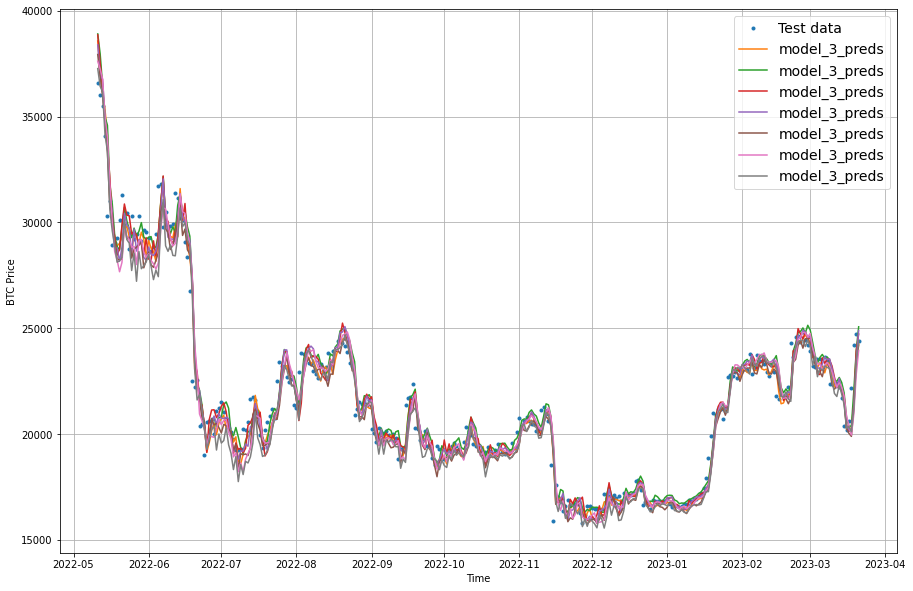

In [75]:
offset=300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds,start=offset,format="-", label="model_3_preds")

Since our predictions were multi-dimensional, the plot predictions also look like stacked every timesteps together.

Let's fix this by aggregating our model's predictions.

**Note**: Aggregating the results of the predictions lead to lose in information from it's original predictions because it was originally predicted for 7 days but if we aggregate it in 1 day then it'll lose the detailed predictions.

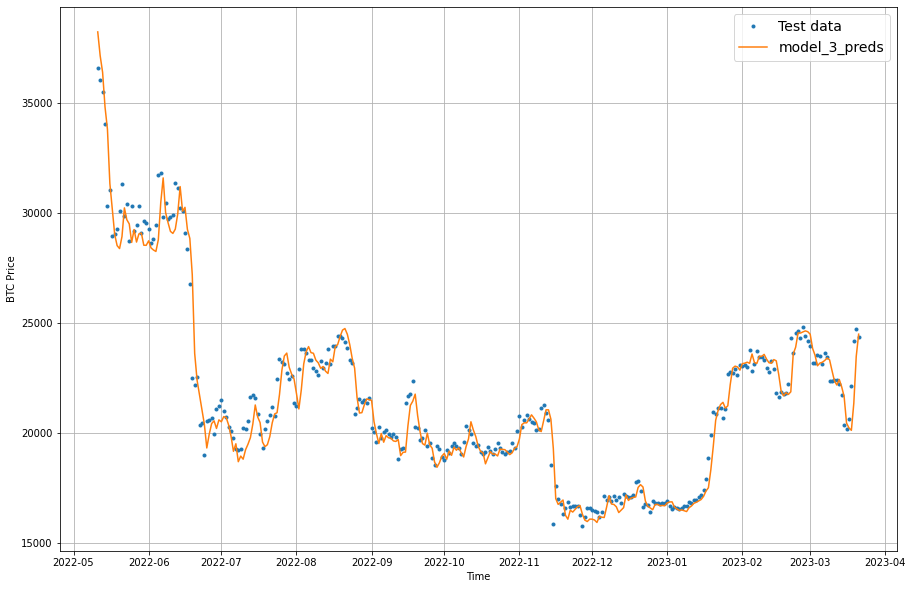

In [76]:
offset = 300
plt.figure(figsize=(15,10))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=offset, format="-" ,label="model_3_preds")

## Which of our model is performing best so far ?

So far, we've trained 3 models which use the same architecture but use different data inputs.

Let's compare them with the naive model to see which model is performing the best so far.

<Axes: >

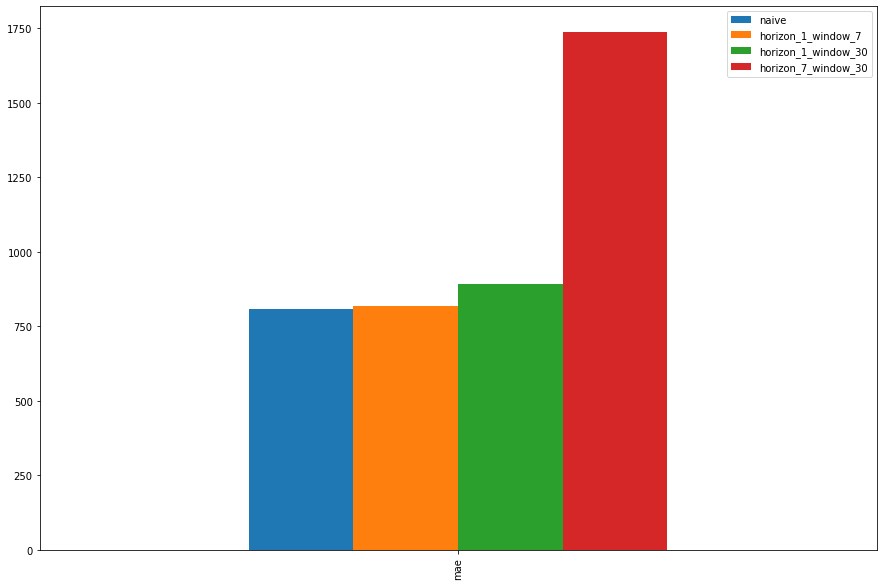

In [77]:
pd.DataFrame({"naive":naive_results['mae'],
              "horizon_1_window_7":model_1_results['mae'],
              'horizon_1_window_30': model_2_results['mae'],
              'horizon_7_window_30': model_3_results['mae']}, index=["mae"]).plot(kind='bar', figsize=(15,10))

Naive model is hard to beat in an open system, but `model_1` with HORIZON 1 and WINDOW SIZE 7 looks to be performing closest. So let's continue our experiments with only these set of horizon and window size.

💡 **Resource**: Due to autocorrelation in the time series data, naive model often performs best because the value of `t` will be closer to `t-1`. Today's value is probably pretty close to yesterday's value. This isn't always the case but when it is, a naive model will often get fairly good results.

Some more about how autocorrelation influences a model's predictions, [How (not) to use Machine learning for Time series forecasting : Avoiding the pitfalls](https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424)